# **Importing Libraries**

In [1]:
# Install missing packages
#%pip install pandas seaborn statsmodels scikit-learn


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#import linear model
from sklearn.linear_model import LinearRegression

#import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# **Importing the Merged Dataset for further Evaluation**

In [2]:
# setting the file path - locally.
file_path = './data_store_sales/'
# Load the merged files into pandas DataFrames
df_train= pd.read_csv(file_path+'merged_dataset.csv')

In [15]:
# reading the merged dataset
df_train.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event
0,24,105574,2013-01-02,18790.0,12.0,0,0,93.140000,2605,0,0
1,24,105574,2013-01-03,59692.0,1.0,0,0,92.970000,2462,0,0
2,24,105574,2013-01-04,99664.0,3.0,0,0,93.120000,2607,0,0
3,24,105574,2013-01-05,140805.0,4.0,0,0,93.146667,2578,0,0
4,24,105574,2013-01-06,182800.0,7.0,0,0,93.173333,2061,0,0


In [16]:
df_train_2013_01_02 = df_train[(df_train['store_nbr'] == 24) & (df_train['date'] == '2013-01-02')]
df_train_2013_01_02.head(7)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event
0,24,105574,2013-01-02,18790.0,12.0,0,0,93.14,2605,0,0
1687,24,105575,2013-01-02,18791.0,2.0,0,0,93.14,2605,0,0
3374,24,105577,2013-01-02,18792.0,1.0,0,0,93.14,2605,0,0
5061,24,105693,2013-01-02,18793.0,7.0,0,0,93.14,2605,0,0
6748,24,105737,2013-01-02,18794.0,17.0,0,0,93.14,2605,0,0
8435,24,105857,2013-01-02,18795.0,1.0,0,0,93.14,2605,0,0
10122,24,106716,2013-01-02,18796.0,3.0,0,0,93.14,2605,0,0


In [3]:
df_train = df_train.drop(columns=['id'])
df_train.shape

(35069356, 10)

In [18]:
df_train.isnull().sum()

store_nbr       0
item_nbr        0
date            0
unit_sales      0
onpromotion     0
outlier         0
dcoilwtico      0
transactions    0
is_holiday      0
is_event        0
dtype: int64

# **Key Characteristics of Time-Series Data: Autocorrelation**
 

Many forecasting models (like ARIMA) require the data to meet certain assumptions before you can apply them. Two key things we check are:

**Autocorrelation:** Some models rely on autocorrelation (e.g., AR models), while others assume minimal autocorrelation in the residuals (model errors).

**Stationarity:** Non-stationary data can cause forecasting models like ARIMA to fail or produce misleading results.

**☝🏼Autocorrelation**

Autocorrelation means a time series is correlated with its past values (lags).

Autocorrelation tells us how much today’s sales are influenced by previous days. If sales today are similar to yesterday, or the same day last week, the data has temporal dependence—and we can model that!

**The most common and useful tools for analyzing autocorrelation in time series are:**

**1. Quick visual inspection with an autocorrelation plot:** Quick visual inspection of autocorrelation, especially in early EDA.

**2. Autocorrelation Function (ACF):** how much each lag is correlated after controlling for earlier lags, and **Partial Autocorrelation Function (PACF):** how much each lag is correlated with the series. 

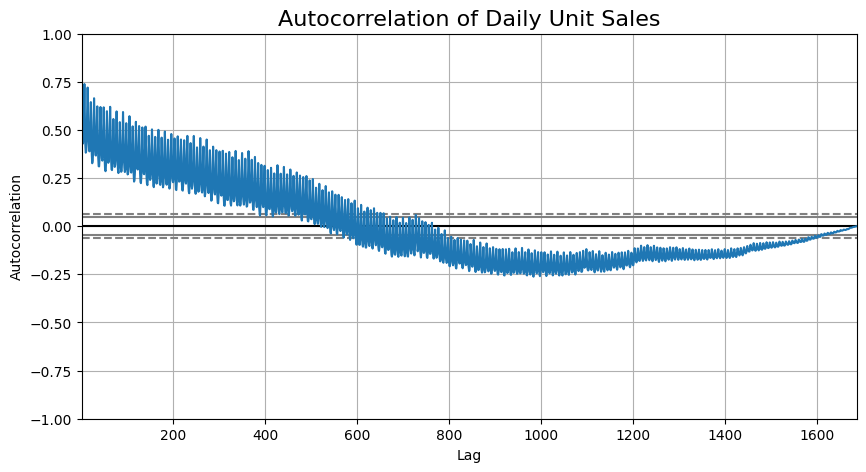

In [19]:
from pandas.plotting import autocorrelation_plot

# Aggregate total sales per day
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plot autocorrelation
plt.figure(figsize=(10, 5))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16)
plt.show()


Each vertical bar shows the correlation between the sales today and the sales n days ago (that’s the "lag").

Lag = 1 → yesterday
Lag = 7 → same day last week
…and so on.

**The height of each bar tells you how similar today is to past days.**

**Interpretation:**

If the autocorrelation curve stays high even at lags of 1, 2, 3, ..., it means past values strongly influence future values.
That means lag features (like sales 1 day ago, 7 days ago, etc.) can help your model predict better.

**How to interpret this chart**

**1.Strong autocorrelation at short lags (left side):**

You can see the bars start very high (around 0.75), which means:
Sales today are very similar to the past few days' sales.
This makes sense—sales in time series usually have inertia and don’t jump around wildly.

**2.Slow decay over time:**

The bars gradually decrease instead of dropping off immediately.
That tells us:
Even sales from hundreds of days ago still have some predictive value, although weaker.

**3.Dotted lines = statistical significance:**

Bars above the horizontal dashed lines mean those lags are statistically significant.
As you can see, a lot of the early lags are well above the line—especially the first \~300 days.

**So what? Why does this matter?**

Because data is strongly autocorrelated, it means:

Lag features (like unit_sales 1, 7, or 30 days ago) are very useful for prediction.
**Time-series models (like XGBoost, LightGBM, LSTM, or ARIMA) will benefit from including historical sales data as input.**

# **Key Characteristics of Time-Series Data: Stationarity**

**☝🏼Stationarity** means that the mean, variance, and seasonality of time series do not change over time. 

**Non-stationary data**—such as a growing trend, changing variability, or repeating seasonal patterns—can cause trouble for traditional time series models like ARIMA, which we’ll explore in the next sprint. These models assume that the data is stationary, meaning its statistical properties remain constant over time.

We will use a visual check first, and then a Statistical test called **Augmented Dickey-Fuller (ADF)** to check if the data is stationary.

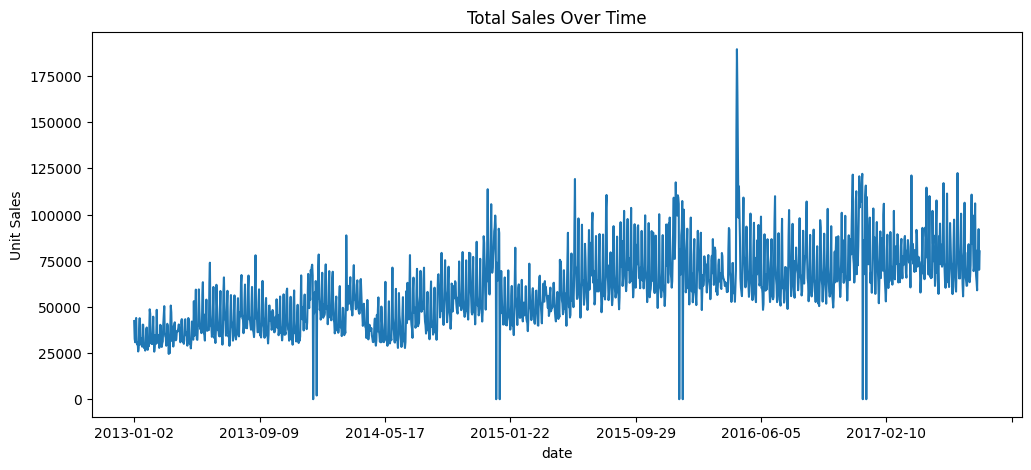

In [20]:
sales_by_date.plot(figsize=(12,5), title='Total Sales Over Time')
plt.ylabel('Unit Sales')
plt.show()


**This plot of Total Sales Over Time clearly reveals:**

**1.Trend:** There is a visible upward trend—sales are generally increasing over time.

**2.Seasonality:** There are regular cycles (peaks and dips) that suggest seasonal patterns.

**3.Increasing Variance:** The fluctuations (height of the spikes) get larger as time goes on.

**Conclusion:** The data is non-stationary.

Because the trend, seasonality, and variance all change over time, we say this time series is non-stationary.
That’s common in sales data—and it’s important because many forecasting models require stationary inputs (e.g. ARIMA).

# **Feature Engineering**   

## **1.Time Based Features (from date)**

In [4]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['dayofweek'] = df_train['date'].dt.dayofweek        # 0 = Monday
df_train['is_weekend'] = df_train['dayofweek'].isin([5, 6]).astype(int)
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['weekofyear'] = df_train['date'].dt.isocalendar().week
df_train['year'] = df_train['date'].dt.year
df_train['is_month_start'] = df_train['date'].dt.is_month_start.astype(int)
df_train['is_month_end'] = df_train['date'].dt.is_month_end.astype(int)

In [22]:
print(df_train['is_month_start'].value_counts())
print(df_train['is_month_end'].value_counts())

is_month_start
0    33926016
1     1143340
Name: count, dtype: int64
is_month_end
0    33926016
1     1143340
Name: count, dtype: int64


In [23]:
df_train.head(5)

,store_nbr,item_nbr,date,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event,dayofweek,is_weekend,month,day,weekofyear,year,is_month_start,is_month_end
0,24,105574,2013-01-02,12.0,0,0,93.140000,2605,0,0,2,0,1,2,1,2013,0,0
1,24,105574,2013-01-03,1.0,0,0,92.970000,2462,0,0,3,0,1,3,1,2013,0,0
2,24,105574,2013-01-04,3.0,0,0,93.120000,2607,0,0,4,0,1,4,1,2013,0,0
3,24,105574,2013-01-05,4.0,0,0,93.146667,2578,0,0,5,1,1,5,1,2013,0,0
4,24,105574,2013-01-06,7.0,0,0,93.173333,2061,0,0,6,1,1,6,1,2013,0,0


## **2.Lag Features (based on past values)**

### **Seasonal Decomposition**

/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_1645/1123992455.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_sales = daily_sales.fillna(method='ffill')


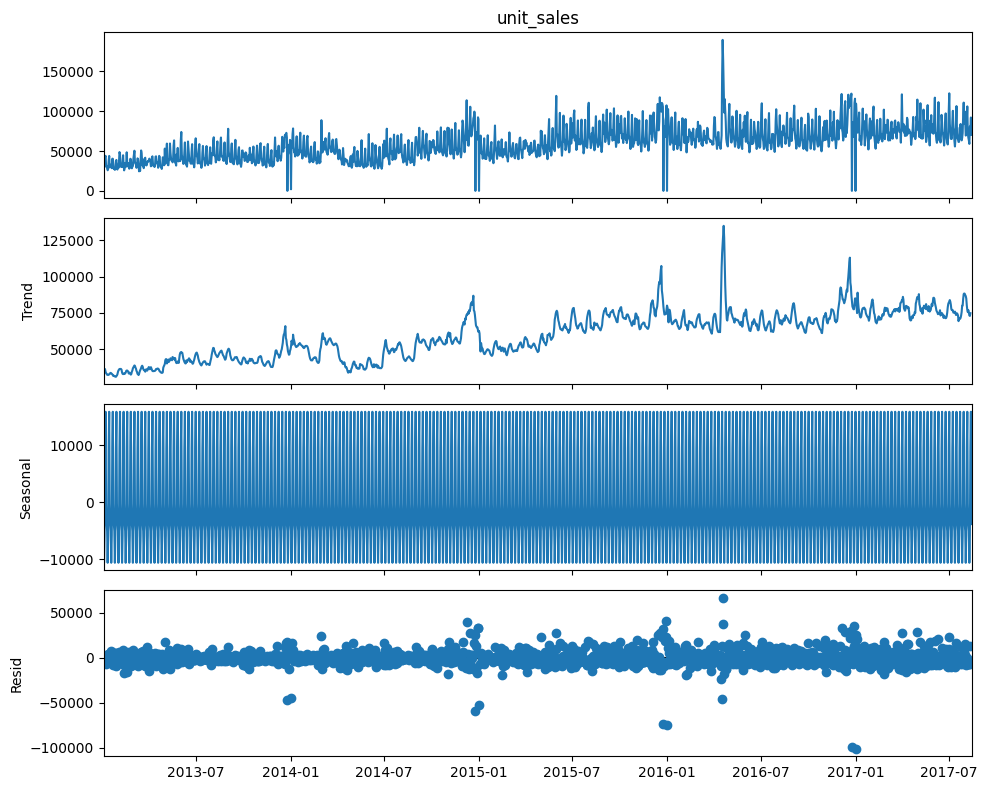

In [24]:
# seasonal decomposition the df_train
# Make sure the  data is sorted and indexed properly
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.sort_values('date')

# Optional: aggregate if data is per item/store
daily_sales = df_train.groupby('date')['unit_sales'].sum()

# Set date as index
daily_sales = daily_sales.asfreq('D')  # Ensure a daily frequency

# Fill missing days if any
daily_sales = daily_sales.fillna(method='ffill')

# Decompose (assume additive model, can change to 'multiplicative' if needed)
decomposition = seasonal_decompose(daily_sales, model='additive', period=7)  # weekly seasonality

# Plot components
plt.rcParams.update({'figure.figsize': (10, 8)})
decomposition.plot()
#plt.suptitle('Seasonal Decomposition of Unit Sales', fontsize=16)
plt.show()


**This is an additive model. In an additive model, the seasonal component stays roughly constant in size even as the trend increases.
(in Multiplicative model, the seasonal fluctuations grows/shrinks with the trend)**


### **Test for stationarity: Statistical test Augmented Dickey-Fuller (ADF)**

**The ADF test** checks for the presence of a unit root, which would indicate that the series is non-stationary.

**1.Null hypothesis (H₀):** The series has a unit root → non-stationary
**2.Alternative hypothesis (H₁):** The series is stationary
**Result Interpretation:**
If p-value < 0.05, the series is stationary (good for modeling).
If p-value > 0.05, the series is non-stationary — and it’s important because many forecasting models require stationary inputs (e.g. ARIMA). 

In [25]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', '#Observations Used']
    for value, label in zip(result[:4], labels):
        print(f'{label: <25} : {value}')
    
    if result[1] <= 0.05:
        print("✅ Strong evidence against the null hypothesis (unit root), so the series is **stationary**.")
    else:
        print("❌ Weak evidence against the null hypothesis, so the series is **non-stationary**.")

# Example usage
adf_test(daily_sales, title='Total Unit Sales')

Augmented Dickey-Fuller Test: Total Unit Sales
ADF Test Statistic        : -2.874804552839228
p-value                   : 0.04835731337535465
#Lags Used                : 22
#Observations Used        : 1664
✅ Strong evidence against the null hypothesis (unit root), so the series is **stationary**.


**From visual presentation we can see the series is non stationary but from ADF test the esult suggessted that series is stationary. (P value is 0.048 ≤ 0.05 , so series is ✅ Stationary (good for modeling), if P value were > 0.05 , then series would be ❌ Non-stationary and we had to apply differencing, ZScore, MinMax scaling, log, etc to make it stationary.)**

**Visual Inspection from Seasonal Decomposition**

	•	The plot clearly shows:
	•	Upward trend over time
	•	Seasonal patterns
	•	Possibly increasing variance
	•	Normally, these indicate non-stationarity.

**ADF Test Results**

	•	ADF Statistic = -2.875, p-value ≈ 0.048
	•	At the 5% significance level, p < 0.05 → reject the null hypothesis (unit root) → stationary.
	•	The test suggests that after accounting for autocorrelation, the series is already stationary.

⸻

**Reconciling the Difference**

	•	The ADF test is sensitive to the sample size and strong seasonality.
	•	Series might be trend-stationary (stationary after removing a deterministic trend) or seasonally stationary in some statistical sense.
	•	Strong seasonality can sometimes “mask” the trend effect in the ADF test.
	•	The visual pattern might still require detrending/seasonal adjustment for modeling, even if the test says “stationary.”

⸻

**Final Conclusion**

	•	Statistically (ADF): The series is stationary at the 5% significance level.
	•	Practically for modeling: The visible trend and seasonality mean you should still remove trend and seasonality before using models like ARIMA, to avoid biased forecasts.
	•	Best approach: Treat it as trend & seasonality present → difference/seasonally difference before modeling, even though the ADF suggests stationarity.

### **Measure strength of trend & seasonality**

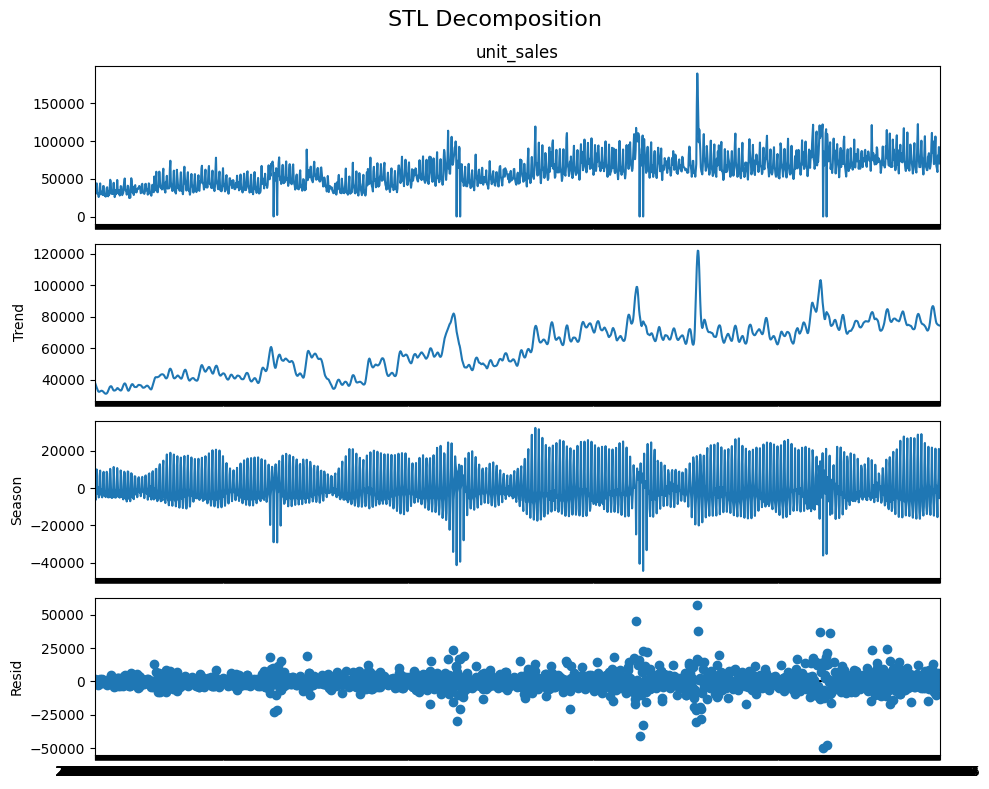

Strength of Trend: 0.87
Strength of Seasonality: 0.75


In [27]:
# STL decomposition
from statsmodels.tsa.seasonal import STL
stl = STL(sales_by_date, period=7)  # again, adjust period based on your seasonality
res = stl.fit()

# Plot STL decomposition
res.plot()
plt.suptitle("STL Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

# Calculate strength of trend and seasonality
# Based on Hyndman’s definition: Strength = 1 - (variance of remainder / variance of (component + remainder))

import numpy as np

trend_strength = 1 - (np.var(res.resid) / np.var(res.trend + res.resid))
seasonal_strength = 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid))

print(f"Strength of Trend: {trend_strength:.2f}")
print(f"Strength of Seasonality: {seasonal_strength:.2f}")

**🔹 Trend**

The trend line rises clearly from ~2013 to ~2016, confirming a non-stationary mean.
There's a visible increase in overall sales levels over time.

**🔹 Seasonality**

In the STL plot, seasonality is clear and dynamic — the seasonal component varies in amplitude across time.

**🔹 Residuals**

The residuals are somewhat random, though not perfectly flat.
A few spikes remain, especially around holidays or demand shocks (e.g., big dips or spikes), which decomposition cannot fully account for.
This means STL has done a good job but may still benefit from further outlier treatment or advanced modeling.

**Measure strength of trend and seasonality:**

Use the decomposition output to quantify how dominant trend and seasonal components are.
This helps decide whether you need to remove or adjust for them before modeling.

**How to Interpret Strength Values:**

Strength of Trend: 0.87
Strength of Seasonality: 0.75

Close to 1.00 → very strong trend/seasonality
Close to 0.00 → weak or no trend/seasonality

**1. Strength of Trend = 0.87** → This is very close to 1, meaning the data has a very strong long-term upward or downward movement. In your case, it’s an upward trend, so sales are steadily increasing over time.

**2. Strength of Seasonality** = 0.75 → This is also high, indicating clear and repeating seasonal patterns (likely weekly cycles in your case).

**Final conclusion:**

The time series is dominated by a strong long-term upward trend and a pronounced seasonal pattern.
This means:

1. Forecasting models should explicitly include both trend and seasonality (e.g., SARIMA, Prophet, or seasonal decomposition before modeling).
2. Short-term fluctuations are less important than the predictable trend + seasonal cycles.
3. data is strongly non-stationary due to both trend and seasonality.
4. To make my data suitable for models like ARIMA, you’ll likely need to remove the trend and the seasonality. You can also forecast trend and seasonality individually, then recombine for a full forecast.


In the next stage, we’ll dive into techniques for working with non-stationary data. Here's a quick preview of what’s ahead:

**Use models that can naturally handle non-stationary data, such as LSTM or XGBoost (with appropriate feature engineering).**

**When using models that assume stationarity—like ARIMA—you’ll need to prepare your data accordingly.** This can include:
**Removing trends**, for example through differencing (subtracting today's value from yesterday's) or other detrending techniques.
**Eliminating seasonality**, using tools like STL decomposition.
**Stabilizing variance**, by applying transformations such as log, square root, or Box-Cox.

### **Autocorrelation (AFC)**

Autocorrelation Function (ACF) plot, which helps visualize the correlation of a time series with its past values (lags). It has both direct and indirect effect of intermidiates lags.

<Figure size 1000x500 with 0 Axes>

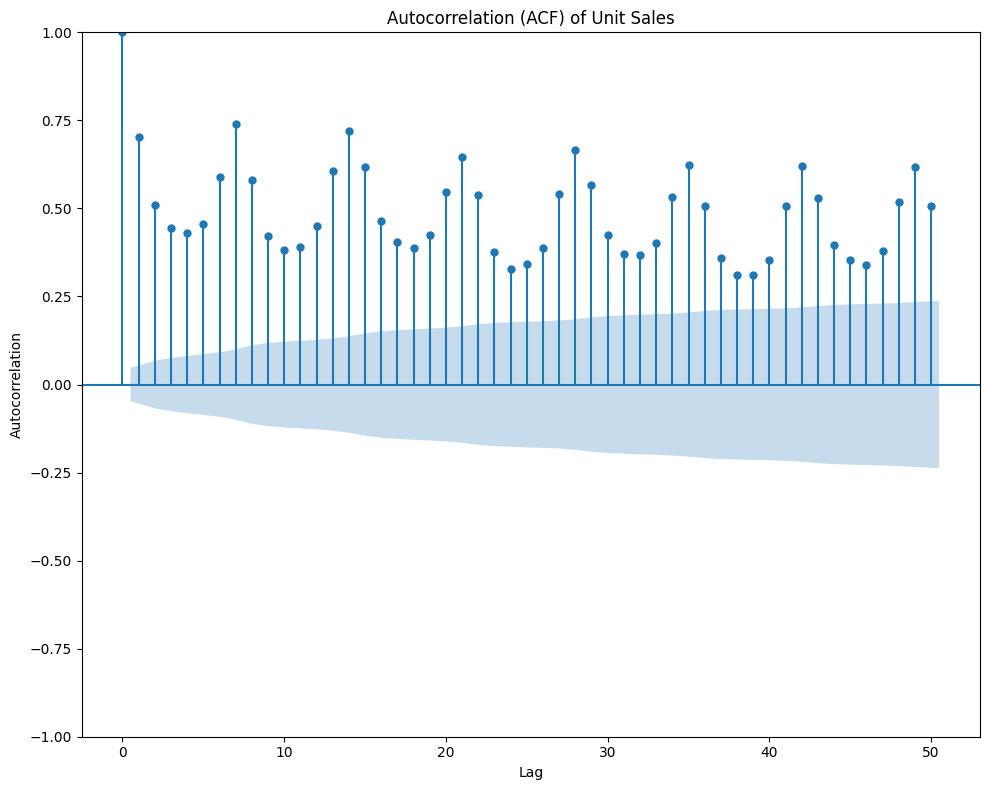

In [28]:

# Assume daily_sales is your time series and already preprocessed
plt.figure(figsize=(10, 5))
plot_acf(daily_sales.dropna(), lags=50)
plt.title('Autocorrelation (ACF) of Unit Sales')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()
#Using lags=50 is a practical default — it shows how  time series correlates with its past values up to 50 days back.

✅ Key Observations from the ACF Plot:
1.	**Strong autocorrelation at lag 1**
	•	Value close to 1 at lag 1 → very high similarity between today and yesterday’s sales.
	•	Suggests high temporal continuity.
2.	**Significant spikes at regular intervals**
	•	Many lags (e.g., 7, 14, 21…) have significant autocorrelation.
	•	This indicates weekly seasonality (which makes sense in retail due to shopping patterns).
3.	**All bars above blue shaded area**
	•	The blue region is the 95% confidence interval.
	•	Bars outside of it are statistically significant, not due to random noise.
	•	autocorrelations up to lag 50 are very strong — indicating non-stationarity.

### **Partial Autocorrelation (PAFC)**

The PACF shows how much each lag individually contributes to the time series after removing the effects of earlier lags.

<Figure size 1000x500 with 0 Axes>

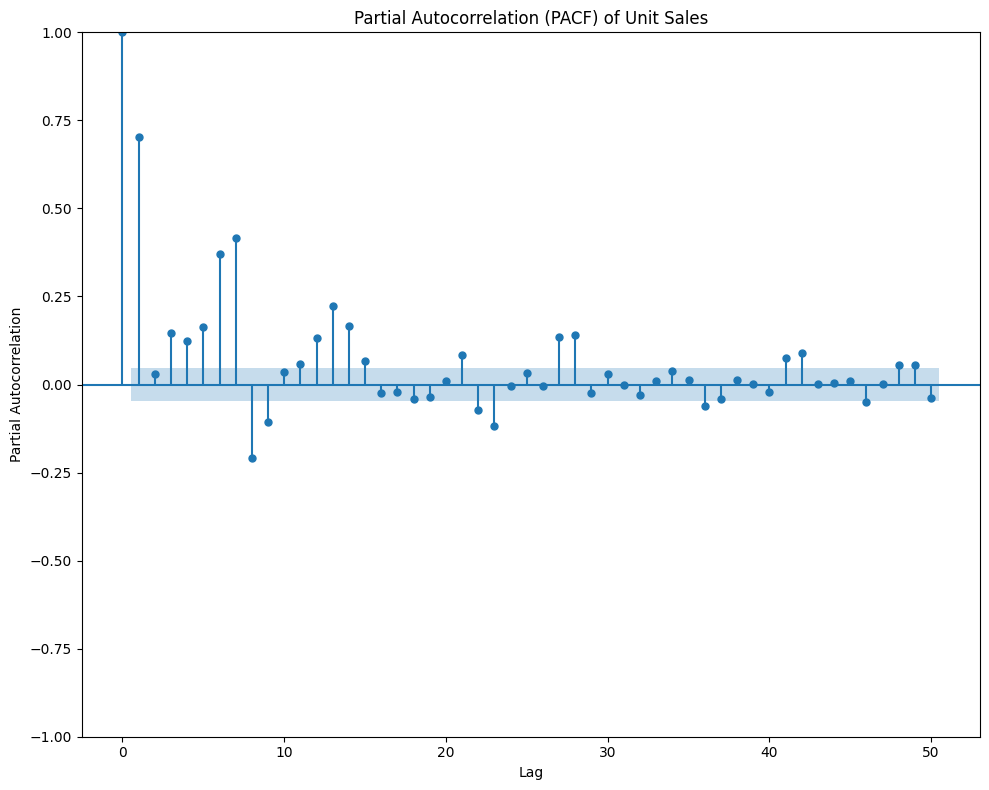

In [16]:

plt.figure(figsize=(10, 5))
plot_pacf(daily_sales.dropna(), lags=50, method='ywm')
plt.title('Partial Autocorrelation (PACF) of Unit Sales')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

✅ Key Observations:
1.	**Strong spike at lag 1**
	•	Partial autocorrelation is very high at lag 1 → most of the series’ “memory” is captured by the first previous day.
	•	Suggests strong AR(1) behavior.
2.	**Significant spikes at lags 2–5 and some intermittent later lags**
	•	Indicates additional autoregressive effects beyond lag 1.
	•	But most values drop off quickly after lag ~7–10.
3.	**Lags beyond ~10 mostly stay within the blue confidence band**
	•	These are likely not statistically significant, i.e., they don’t add much unique explanatory power beyond the earlier lags.

**✅ Which Lag Features to Create?**

ACF and PACF plots suggest the following:

🔁 Short-term Lags (based on PACF):
	•	Strong autocorrelation up to lag 5–7
	•	These capture recent momentum or AR behavior

👉 Use: lag_1, lag_5, …, lag_7

🔁 Seasonal Lags (based on ACF):
	•	Regular spikes every 7 lags → indicates weekly seasonality

👉 Use: lag_7, lag_14, lag_21 (i.e., 1, 2, 3 weeks ago)

In [29]:
# Lag features (unit_sales)
df_train = df_train.sort_values(['store_nbr', 'item_nbr', 'date'])  # important for shifting

# Lag features (unit_sales)
for lag in [1, 7,14,30,60]:
    df_train[f'lag_{lag}'] = df_train.groupby (['store_nbr', 'item_nbr']) ['unit_sales'].shift(lag)

In [30]:
df_train.isnull().sum()

store_nbr               0
item_nbr                0
date                    0
unit_sales              0
onpromotion             0
outlier                 0
dcoilwtico              0
transactions            0
is_holiday              0
is_event                0
dayofweek               0
is_weekend              0
month                   0
day                     0
weekofyear              0
year                    0
is_month_start          0
is_month_end            0
lag_1               20788
lag_7              145516
lag_14             291032
lag_30             623640
lag_60            1247280
dtype: int64

In [31]:
df_train.head(5)

,store_nbr,item_nbr,date,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event,...,day,weekofyear,year,is_month_start,is_month_end,lag_1,lag_7,lag_14,lag_30,lag_60
11420990,24,96995,2013-01-02,0.0,0,0,93.140000,2605,0,0,...,2,1,2013,0,0,NaN,NaN,NaN,NaN,NaN
11420991,24,96995,2013-01-03,0.0,0,0,92.970000,2462,0,0,...,3,1,2013,0,0,0.0,NaN,NaN,NaN,NaN
11420992,24,96995,2013-01-04,0.0,0,0,93.120000,2607,0,0,...,4,1,2013,0,0,0.0,NaN,NaN,NaN,NaN
11420993,24,96995,2013-01-05,0.0,0,0,93.146667,2578,0,0,...,5,1,2013,0,0,0.0,NaN,NaN,NaN,NaN
11420994,24,96995,2013-01-06,0.0,0,0,93.173333,2061,0,0,...,6,1,2013,0,0,0.0,NaN,NaN,NaN,NaN


## **3.Rolling Window / Exponential Moving Avg. Features (smoothing + trend detection)**

Rolling mean features help capture local trends, reduce noise, and provide the model with valuable temporal context, all of which improve the accuracy of sales forecasting models.A rolling window smooths the data by averaging (or summarizing) values over a fixed number of past days. Rolling Std means how much have unit sales varied over the past 7 days.

In [32]:
# Weekly seasonality (common in retail), sales pattern repeats every week, shift 1 to prevent data leakage
# Define rolling windows
windows = [7, 14, 30]

# Generate rolling features
for w in windows:
    df_train[f'rolling_mean_{w}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=w).mean())

    df_train[f'rolling_std_{w}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=w).std())
# Exponential moving average
# Define EWM spans (like 7-day, 14-day, 30-day)
spans = [7, 14, 30]

# Generate EWM features
for span in spans:
    df_train[f'ewm_mean_{span}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).ewm(span=span, adjust=False).mean())
    df_train[f'ewm_std_{span}'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).ewm(span=span, adjust=False).std())

In [33]:
df_train.head(5)

,store_nbr,item_nbr,date,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event,...,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,ewm_mean_7,ewm_std_7,ewm_mean_14,ewm_std_14,ewm_mean_30,ewm_std_30
11420990,24,96995,2013-01-02,0.0,0,0,93.140000,2605,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11420991,24,96995,2013-01-03,0.0,0,0,92.970000,2462,0,0,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11420992,24,96995,2013-01-04,0.0,0,0,93.120000,2607,0,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
11420993,24,96995,2013-01-05,0.0,0,0,93.146667,2578,0,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
11420994,24,96995,2013-01-06,0.0,0,0,93.173333,2061,0,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


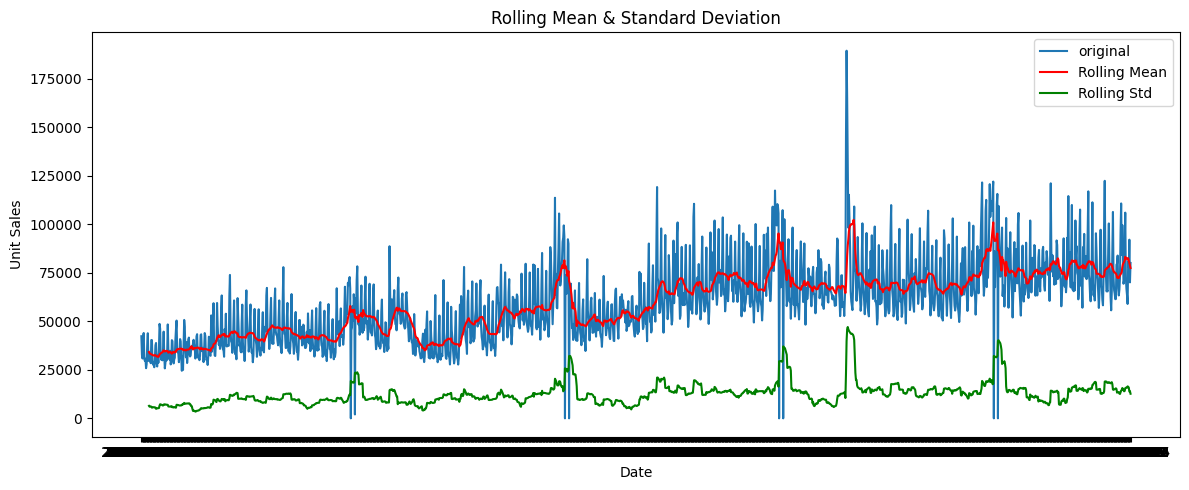

In [38]:
rolling_mean = sales_by_date.rolling(window=14).mean()
rolling_std = sales_by_date.rolling(window=14).std()

plt.figure(figsize=(12,5))
plt.plot(sales_by_date, label='original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.ylabel('Unit Sales')
plt.xlabel('Date')
plt.tight_layout()
plt.legend()
plt.show()

**This Rolling Mean & Standard Deviation plot shows:**

1. Upward Trend → The red rolling mean line is clearly increasing over time, indicating consistent sales growth.
2. Seasonal Spikes → Blue original data line has recurring peaks, likely tied to holidays or promotions.
3. Variability Changes → Green rolling standard deviation line shows fluctuations over time, with noticeable spikes during peak seasons, meaning variability increases during high-demand periods.
4. Non-stationarity Visually → Since both rolling mean and std dev are not constant, the raw series appears non-stationary, despite the ADF test indicating stationarity (possibly due to strong seasonality influencing the test).

**Conclusion:**

Sales data is trending upward with strong seasonal peaks and occasional high-variability events. For forecasting, detrending and deseasonalizing will be important before applying stationary models like ARIMA.

## **4.Promotion Effects**

onpromotion: (binary, 0 and 1), Now Create lagged promo indicators. This lag is creating a feature that tells you whether the same product in the same store was on promotion exactly one week earlier.

Why it’s done:

	•	In sales forecasting, promotional effects often have lagged impacts — sales can increase before or after the promotion week.
	•	By grouping on store_nbr and item_nbr, you ensure the shift happens within each product–store combination (no mixing between products or stores).
	•	.shift(7) moves the onpromotion column down by 7 days, aligning with a weekly lag.

In [39]:
df_train['promo_last_week'] = df_train.groupby(['store_nbr', 'item_nbr'])['onpromotion'].shift(7)

## **5.External Effects (Oil Price)**

dcoilwtico (oil price), which can be useful if: It impacts transportation costs or inventory planning

In [40]:
df_train['oil_price_lag_3'] = df_train['dcoilwtico'].shift(3)
df_train['oil_price_change'] = df_train['dcoilwtico'].pct_change()

## **6.Holiday/Event**

It helps the model learn “should we expect a sales jump tomorrow due to holiday or events?”

In [41]:
# Days until next holiday/event (basic flag shift)
df_train['next_is_holiday'] = df_train['is_holiday'].shift(-1).fillna(0).astype(int)
df_train['next_is_event'] = df_train['is_event'].shift(-1).fillna(0).astype(int)

## **7.Features from Transaction**

The transactions column in dataset is a valuable feature that represents customer foot traffic or activity per store per day. But its not given per item for each store number. Hence I am droping this column


In [42]:
df_train = df_train.drop(columns=['transactions'])

## **8. Convert Identifiers to Category**

In [43]:
# Convert identifiers to category
df_train['store_nbr'] = df_train['store_nbr'].astype('category')
df_train['item_nbr'] = df_train[ 'item_nbr'].astype('category')

## **9.Features from Outlier**

This tells the model: “Was there an outlier a day/week/month ago?”

In [44]:
# Lagged Outlier Flags
# These capture whether a recent outlier occurred — useful as a memory trigger:

#df_train = df_train.sort_values(['store_nbr', 'item_nbr', 'date'])

for lag in [1, 7, 14, 30]:
     df_train[f'outlier_lag_{lag}'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].shift(lag)

# Rolling Outlier Frequency
# This tracks how frequently outliers occurred in recent days (e.g., store-item has been unstable lately):
df_train['outlier_rolling_mean_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].transform(lambda x: x.shift(1).rolling(7).mean())


/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_1645/3332840895.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train[f'outlier_lag_{lag}'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].shift(lag)
/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_1645/3332840895.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train[f'outlier_lag_{lag}'] = df_train.groupby(['store_nbr', 'item_nbr'])['outlier'].shift(lag)
/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_1645/3332840895.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to T

In [45]:
df_train.shape

(35069356, 44)

## **10. Saving the data as csv after feature engineering**

In [46]:
df_train.to_csv('feature_eng.csv', index=False)

# **Filtering Dataset upto 31-03-2014**

In [ ]:
#max_date='2014-04-01'
#df_train=df_train[df_train['date'] < max_date]


**run the above or the below code**

In [1]:
import pandas as pd

# Load the CSV
df_train = pd.read_csv("feature_eng.csv", parse_dates=["date"])

# Set maximum date for filtering
max_date = pd.Timestamp("2014-04-01")

# Filter the dataset
df_train = df_train[df_train['date'] < max_date]

# Check result
print(df_train.head())
print(f"Filtered rows: {len(df_train)}")

   store_nbr  item_nbr       date  unit_sales  onpromotion  outlier  \
0         24     96995 2013-01-02         0.0            0        0   
1         24     96995 2013-01-03         0.0            0        0   
2         24     96995 2013-01-04         0.0            0        0   
3         24     96995 2013-01-05         0.0            0        0   
4         24     96995 2013-01-06         0.0            0        0   

   dcoilwtico  is_holiday  is_event  dayofweek  ...  promo_last_week  \
0   93.140000           0         0          2  ...              NaN   
1   92.970000           0         0          3  ...              NaN   
2   93.120000           0         0          4  ...              NaN   
3   93.146667           0         0          5  ...              NaN   
4   93.173333           0         0          6  ...              NaN   

   oil_price_lag_3  oil_price_change  next_is_holiday  next_is_event  \
0              NaN               NaN                0              0

In [2]:
print(df_train['date'].min())
print(df_train['date'].max())
print(df_train.shape)

2013-01-02 00:00:00
2014-03-31 00:00:00
(9437752, 44)


### **Saving the filtered dataset**

In [ ]:
#df_train.to_csv('feature_eng_upto_2014.csv', index=False)

In [5]:
# setting the file path - locally.

file_path = './data_store_sales/'
# Load the merged files into pandas DataFrames
df_train_filtered= pd.read_csv(file_path+'feature_eng_upto_2014.csv')

In [25]:
df_train_filtered.head(10)

,store_nbr,item_nbr,date,unit_sales,onpromotion,outlier,dcoilwtico,is_holiday,is_event,dayofweek,...,promo_last_week,oil_price_lag_3,oil_price_change,next_is_holiday,next_is_event,outlier_lag_1,outlier_lag_7,outlier_lag_14,outlier_lag_30,outlier_rolling_mean_7
0,24,96995,2013-01-02,0.0,0,0,93.140000,0,0,2,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
1,24,96995,2013-01-03,0.0,0,0,92.970000,0,0,3,...,NaN,NaN,-0.001825,0,0,0.0,NaN,NaN,NaN,NaN
2,24,96995,2013-01-04,0.0,0,0,93.120000,0,0,4,...,NaN,NaN,0.001613,0,0,0.0,NaN,NaN,NaN,NaN
3,24,96995,2013-01-05,0.0,0,0,93.146667,0,0,5,...,NaN,93.140000,0.000286,0,0,0.0,NaN,NaN,NaN,NaN
4,24,96995,2013-01-06,0.0,0,0,93.173333,0,0,6,...,NaN,92.970000,0.000286,0,0,0.0,NaN,NaN,NaN,NaN
5,24,96995,2013-01-07,0.0,0,0,93.200000,0,0,0,...,NaN,93.120000,0.000286,0,0,0.0,NaN,NaN,NaN,NaN
6,24,96995,2013-01-08,0.0,0,0,93.210000,0,0,1,...,NaN,93.146667,0.000107,0,0,0.0,NaN,NaN,NaN,NaN
7,24,96995,2013-01-09,2.0,0,0,93.080000,0,0,2,...,0.0,93.173333,-0.001395,0,0,0.0,0.0,NaN,NaN,0.0
8,24,96995,2013-01-10,0.0,0,0,93.810000,0,0,3,...,0.0,93.200000,0.007843,0,0,0.0,0.0,NaN,NaN,0.0
9,24,96995,2013-01-11,0.0,0,0,93.600000,0,0,4,...,0.0,93.210000,-0.002239,0,0,0.0,0.0,NaN,NaN,0.0


## **All Features**

In [5]:
df_train_filtered.columns

Index(['store_nbr', 'item_nbr', 'date', 'unit_sales', 'onpromotion', 'outlier',
       'dcoilwtico', 'is_holiday', 'is_event', 'dayofweek', 'is_weekend',
       'month', 'day', 'weekofyear', 'year', 'is_month_start', 'is_month_end',
       'lag_1', 'lag_7', 'lag_14', 'lag_30', 'lag_60', 'rolling_mean_7',
       'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30',
       'rolling_std_30', 'ewm_mean_7', 'ewm_std_7', 'ewm_mean_14',
       'ewm_std_14', 'ewm_mean_30', 'ewm_std_30', 'promo_last_week',
       'oil_price_lag_3', 'oil_price_change', 'next_is_holiday',
       'next_is_event', 'outlier_lag_1', 'outlier_lag_7', 'outlier_lag_14',
       'outlier_lag_30', 'outlier_rolling_mean_7'],
      dtype='object')

In [ ]:
df_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437752 entries, 0 to 9437751
Data columns (total 44 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   store_nbr               int64  
 1   item_nbr                int64  
 2   date                    object 
 3   unit_sales              float64
 4   onpromotion             int64  
 5   outlier                 int64  
 6   dcoilwtico              float64
 7   is_holiday              int64  
 8   is_event                int64  
 9   dayofweek               int64  
 10  is_weekend              int64  
 11  month                   int64  
 12  day                     int64  
 13  weekofyear              int64  
 14  year                    int64  
 15  is_month_start          int64  
 16  is_month_end            int64  
 17  lag_1                   float64
 18  lag_7                   float64
 19  lag_14                  float64
 20  lag_30                  float64
 21  lag_60                  float64

In [ ]:
df_train_filtered.isnull().sum()

store_nbr                       0
item_nbr                        0
date                            0
unit_sales                      0
onpromotion                     0
outlier                         0
dcoilwtico                      0
is_holiday                      0
is_event                        0
dayofweek                       0
is_weekend                      0
month                           0
day                             0
weekofyear                      0
year                            0
is_month_start                  0
is_month_end                    0
lag_1                       20788
lag_7                      145516
lag_14                     291032
lag_30                     623640
lag_60                    1247280
rolling_mean_7             145516
rolling_std_7              145516
rolling_mean_14            291032
rolling_std_14             291032
rolling_mean_30            623640
rolling_std_30             623640
ewm_mean_7                  20788
ewm_std_7     

In [ ]:
df_train_filtered['unit_sales'].describe() 

count    9.437752e+06
mean     2.070799e+00
std      8.254941e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.935000e+03
Name: unit_sales, dtype: float64

**Here’s the summary of your unit_sales distribution:**

	•	Count: ~9.44 million records — very large dataset.
	•	Mean: ~2.07 units sold per record on average — sales are generally small per entry.
	•	Std Dev: ~8.25 — high relative to mean, suggesting large variability.
	•	Min: 0 — many entries with zero sales.
	•	25% / Median / 75%:
	•	25% = 0 → at least a quarter of records had no sales.
	•	50% (Median) = 0 → more than half of records had no sales at all.
	•	75% = 1 → 75% of records sold only 1 unit or less.
	•	Max: 2935 — extreme outliers with very high sales in single entries.

**Key Insight:**

Sales are highly skewed — the majority of entries have zero or very low sales, but there are rare spikes with very large sales numbers. This indicates a strong imbalance, so when modeling, you might need log transformation or outlier treatment to handle the heavy tail.


# **Model (ARIMA)**

Auto Regressive Integrated Moving Average **(ARIMA)** with Seasonal effect is called **SARIMA**. **SARIMA** with exogenous variable or external factors called **SARIMAX**, which  is not meant for multi-series forecasting (like LightGBM/XGBoost).
So I’d apply SARIMAX to just one series — for example:

I am doing, Forecast for unit_sales for store_nbr = 24 and item_nbr = 96995.

## **Step 1: Fit candidate models ARIMA(p, d, q) & predict**

Chosen differencing order d = 0
Selected ARIMA order by BIC: (1, 0, 1), BIC=1334.21

=== ARIMA Evaluation (Test = last 90 days) ===
Order (p,d,q): (1, 0, 1)
MAE  : 1.000
RMSE : 1.092
R²   : -2.188
MAPE : 26.68%  (ignoring zero-actual days)
sMAPE: 155.45%
MASE : 0.816

--- Naïve baseline (t-1) ---
Naive MAE : 0.433
Naive RMSE: 0.901


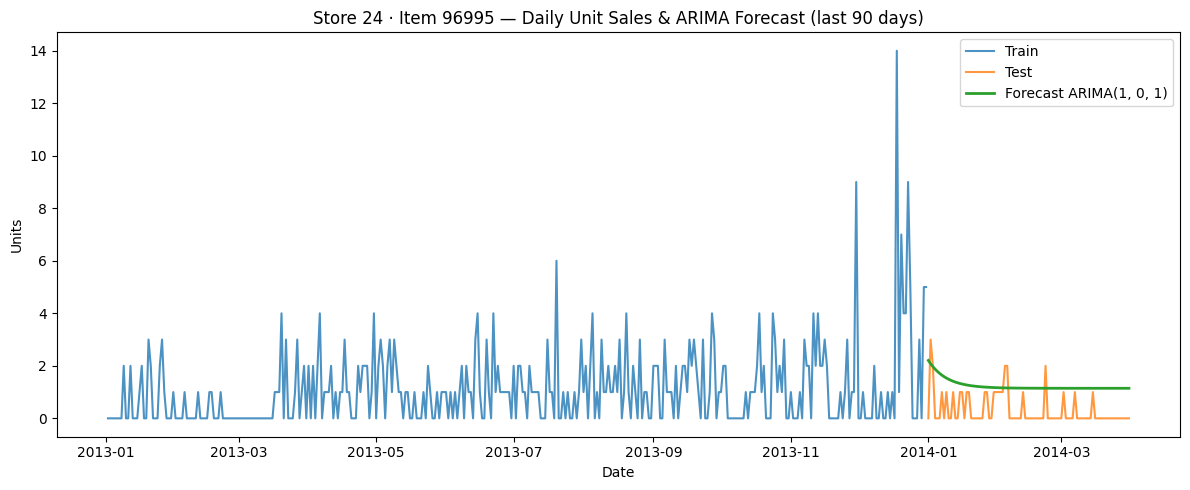

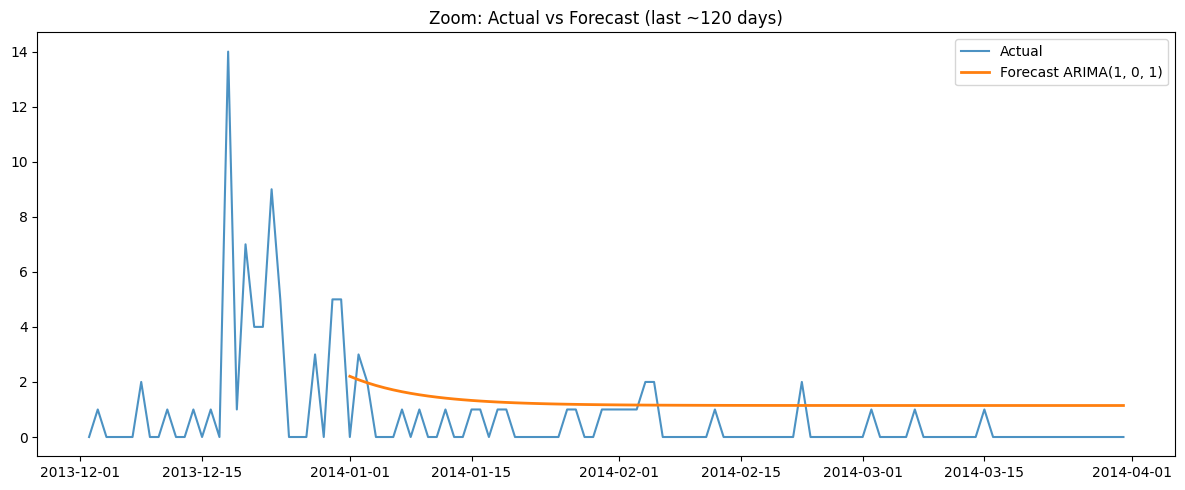

Residual mean: -0.0048


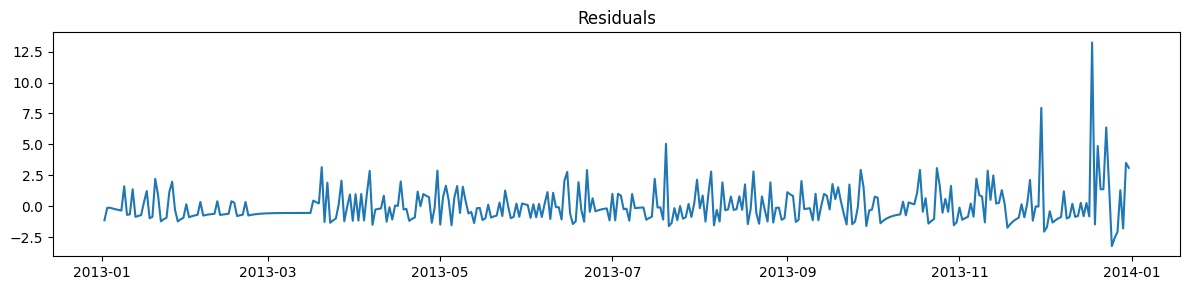

<Figure size 1000x300 with 0 Axes>

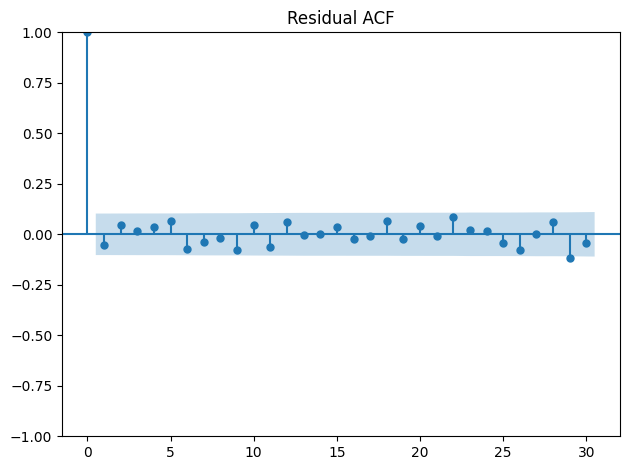


Ljung–Box test (lag 12):
      lb_stat  lb_pvalue
12  12.654636   0.394635


In [6]:
# ---------- ARIMA on unit_sales (Store 24, Item 96995) ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =========================
# 0) START: keep only what ARIMA needs
# =========================
# df_final is your full engineered dataset with many columns
# Keep only date + target, then filter store/item
df_final = df_train_filtered.copy()
cols_needed = ['date', 'unit_sales', 'store_nbr', 'item_nbr']
df_small = df_final[cols_needed].copy()

# Filter to one store & one item
df_small = df_small[(df_small['store_nbr'] == 24) & (df_small['item_nbr'] == 96995)][['date', 'unit_sales']]

# Ensure datetime and sort
df_small['date'] = pd.to_datetime(df_small['date'])
df_small = df_small.sort_values('date')

# Resample to daily and fill missing days with 0 sales
y = (df_small.set_index('date')['unit_sales']
               .resample('D')
               .sum()
               .fillna(0))

# =========================
# 1) Train / Test split (last 90 days test)
# =========================
test_horizon = 90
train = y.iloc[:-test_horizon]
test  = y.iloc[-test_horizon:]

# =========================
# 2) Helper metrics
# =========================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    mask = denom != 0
    return 200 * np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask])

def mase(y_train, y_true, y_pred, m=1):
    # Scale by in-sample naïve forecast (lag m)
    y_train = np.asarray(y_train, dtype=float)
    scale = np.mean(np.abs(y_train[m:] - y_train[:-m])) if len(y_train) > m else np.nan
    err = np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred)))
    return err / scale if scale not in [0, np.nan] else np.nan

# =========================
# 3) Pick d (order of differencing) using ADF
# =========================
def choose_d(series, max_d=2, alpha=0.05):
    # Return smallest d in [0..max_d] such that ADF p < alpha
    s = series.copy()
    for d in range(max_d + 1):
        pval = adfuller(s, autolag='AIC')[1]
        if pval < alpha:
            return d
        s = s.diff().dropna()
    return max_d

d = choose_d(train, max_d=2, alpha=0.05)
print(f"Chosen differencing order d = {d}")

# =========================
# 4) Pick p,q via BIC grid search
# =========================
def grid_search_arima(y_train, d, max_p=7, max_q=7):
    best_bic = np.inf
    best_order = None
    for p in range(0, max_p+1):
        for q in range(0, max_q+1):
            if p==0 and q==0:
                continue
            try:
                model = ARIMA(y_train, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
                res = model.fit(method_kwargs={"warn_convergence": False})
                if res.bic < best_bic:
                    best_bic = res.bic
                    best_order = (p,d,q)
            except Exception:
                continue
    return best_order, best_bic

order, best_bic = grid_search_arima(train, d, max_p=7, max_q=7)
print(f"Selected ARIMA order by BIC: {order}, BIC={best_bic:.2f}")

# =========================
# 5) Fit final ARIMA and forecast last 90 days
# =========================
model = ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False)
res = model.fit()

fcst = res.forecast(steps=len(test))
fcst.index = test.index

# Clip negatives (sales can't be negative)
fcst = fcst.clip(lower=0)

# =========================
# 6) Benchmarks & Metrics
# =========================
# Naïve (yesterday = today) on test window
naive = y.shift(1).iloc[-test_horizon:]
naive = naive.reindex(test.index)

mae  = mean_absolute_error(test, fcst)
rmse = np.sqrt(mean_squared_error(test, fcst))
r2   = r2_score(test, fcst)

# Safe MAPE
mask = test != 0
mape = (np.abs((test[mask] - fcst[mask]) / test[mask])).mean() * 100 if mask.any() else np.nan
smape_val = smape(test, fcst)
mase_val  = mase(train, test, fcst, m=1)

naive_mae  = mean_absolute_error(test, naive)
naive_rmse = np.sqrt(mean_squared_error(test, naive))

print("\n=== ARIMA Evaluation (Test = last 90 days) ===")
print(f"Order (p,d,q): {order}")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")
print(f"MAPE : {mape:.2f}%  (ignoring zero-actual days)")
print(f"sMAPE: {smape_val:.2f}%")
print(f"MASE : {mase_val:.3f}")
print("\n--- Naïve baseline (t-1) ---")
print(f"Naive MAE : {naive_mae:.3f}")
print(f"Naive RMSE: {naive_rmse:.3f}")

# =========================
# 7) Plots
# =========================
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train', alpha=0.8)
plt.plot(test.index,  test,  label='Test', alpha=0.8)
plt.plot(fcst.index,  fcst,  label=f'Forecast ARIMA{order}', linewidth=2)
plt.title('Store 24 · Item 96995 — Daily Unit Sales & ARIMA Forecast (last 90 days)')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.tight_layout()
plt.show()

# Zoomed view (last ~120 days)
plt.figure(figsize=(12,5))
start = test.index.min() - pd.Timedelta(days=30)
plt.plot(y.loc[start:].index, y.loc[start:], label='Actual', alpha=0.8)
plt.plot(fcst.index, fcst, label=f'Forecast ARIMA{order}', linewidth=2)
plt.title('Zoom: Actual vs Forecast (last ~120 days)')
plt.legend(); plt.tight_layout(); plt.show()

# Residual diagnostics
residuals = res.resid
print("Residual mean:", residuals.mean().round(4))

plt.figure(figsize=(12,3))
plt.plot(residuals)
plt.title('Residuals')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plot_acf(residuals, lags=30)
plt.title('Residual ACF')
plt.tight_layout(); plt.show()

lb = acorr_ljungbox(residuals, lags=[12], return_df=True)
print("\nLjung–Box test (lag 12):")
print(lb)

## **Step 2: Evaluation ARIMA Model**

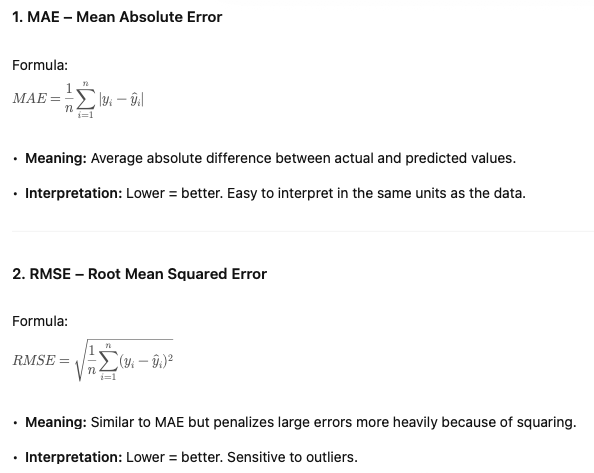

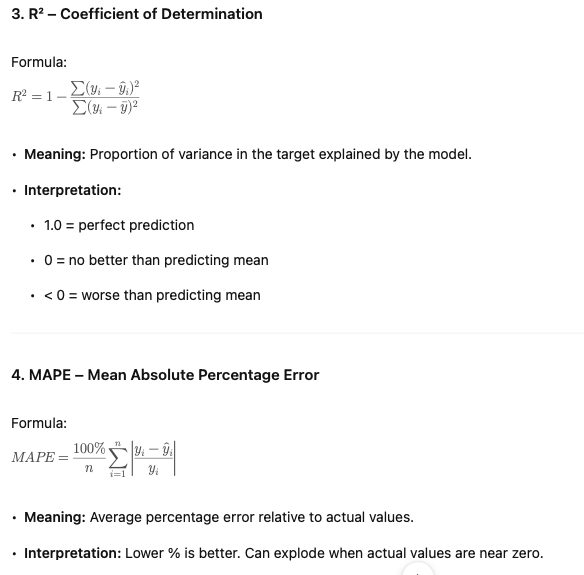
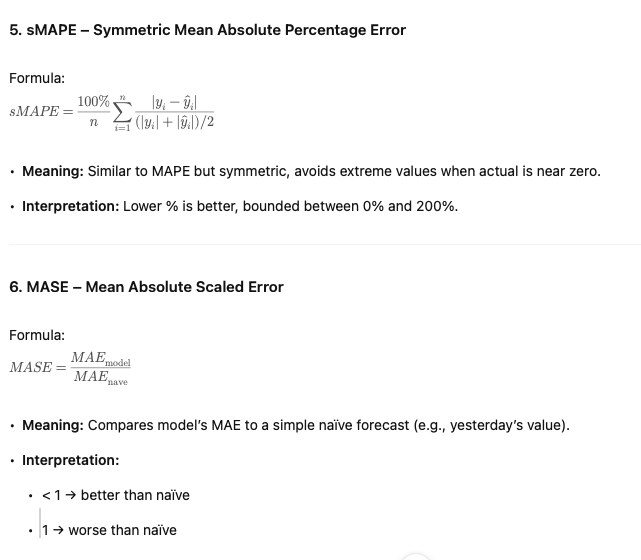
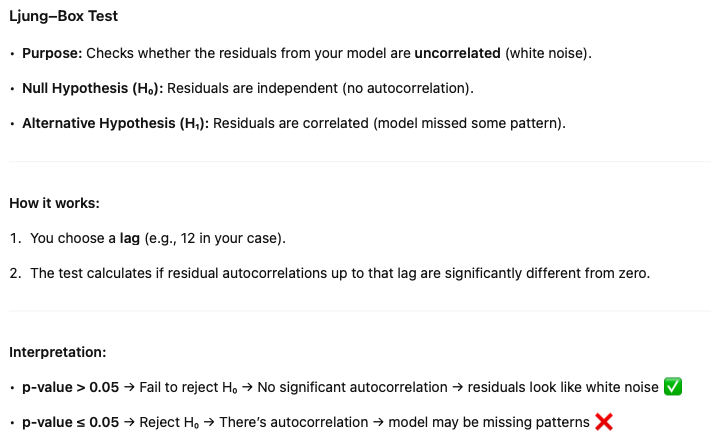


**1. Model Summary**

•	Chosen ARIMA order: (1, 0, 1)

•	Selection method: The model was selected using Bayesian Information Criterion (BIC) minimization.

•	Differencing order (d = 0): Determined from stationarity checks (ADF test, rolling mean/variance plots). No differencing was required because the series appeared stationary after visual inspection and ADF p-value < 0.05.

•	p and q selection: Based on autocorrelation (ACF) and partial autocorrelation (PACF) plots of the stationary series, combined with BIC scoring across candidate models.

•	p (AR terms) controls how many past observations the model uses. PACF showed a significant spike at lag 1 → p ≈ 1.

•	q (MA terms) controls how many past forecast errors are considered. ACF showed a spike at lag 1 → q ≈ 1.

**2. Forecast Performance (Test = Last 90 days)**

•   MAE (1)- Average absolute error ≈ 1 unit.

•   RMSE (1.092)- Slightly higher than MAE, meaning no extreme large errors.

•   R² (-2.188)- Negative R² → Model performs worse than just predicting the mean.

•   MAPE (26.68%)- Average error is ~27% of actual values (ignoring zero sales).

•   sMAPE (155.45%)- Large due to small actual values and many zero days.

•   MASE (0.816)- Better than naïve model if <1.

**3. Naïve Baseline (t-1 prediction)**

•   MAE (0.433) & RMSE (0.901)

•   Naïve performs better here → This happens because sales series is sparse with many zero values, so simply repeating yesterday’s value is hard to beat.

**4. Residual Analysis**

•	Residual mean: ~0 → unbiased.

•	ACF of residuals: All points within confidence bounds → No significant autocorrelation left → Model residuals behave like white noise.

•	Ljung–Box test (lag 12): p-value = 0.39 → Fail to reject H₀ → Residuals are uncorrelated.

**5. Interpretation**

•	The model fits the structure (no autocorrelation in residuals) but predictive performance is weak because:

•	Sales are very sparse with many zeros.

•	High variability from promotions/holidays not captured by plain ARIMA.

•	Naïve model benefits from persistence of zeros.

•	ARIMA is capturing short-term patterns but not external drivers of demand.

⸻

**6. Next Steps**

•	Consider SARIMA to capture seasonality (weekly/monthly patterns).

•	Try ARIMAX including promotions, holidays, oil price as exogenous regressors.

•	Aggregate data (e.g., weekly sales) to reduce sparsity before modeling.




In [7]:
import pickle

# Save the ARIMA model to a file
with open('arima_model.pkl', 'wb') as file:
    pickle.dump(res, file)

print("ARIMA model saved successfully.")

ARIMA model saved successfully.


# **Model (ARIMAX)**

ARIMAX(1, 0, 1) Evaluation Metrics:
  MAE : 0.613
  RMSE: 0.681
  R²  : -0.242
  MAPE: 52.91% (ignoring zero-actual days)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


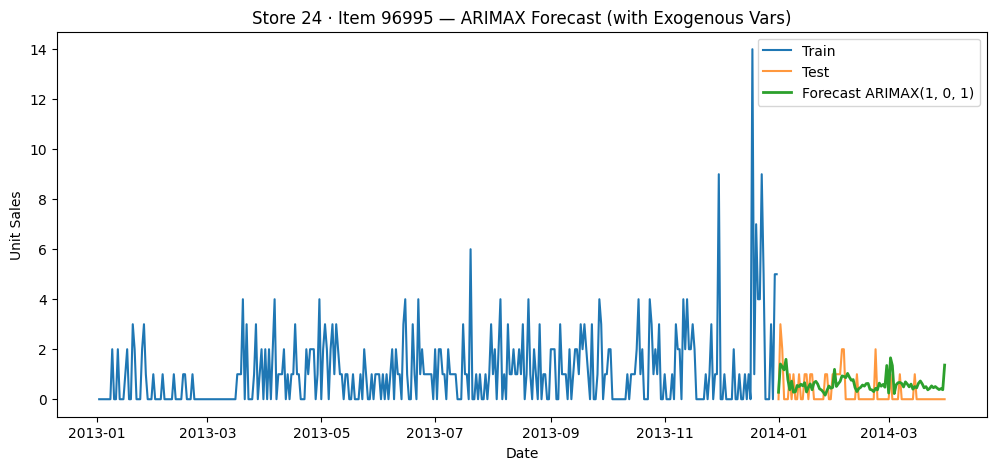

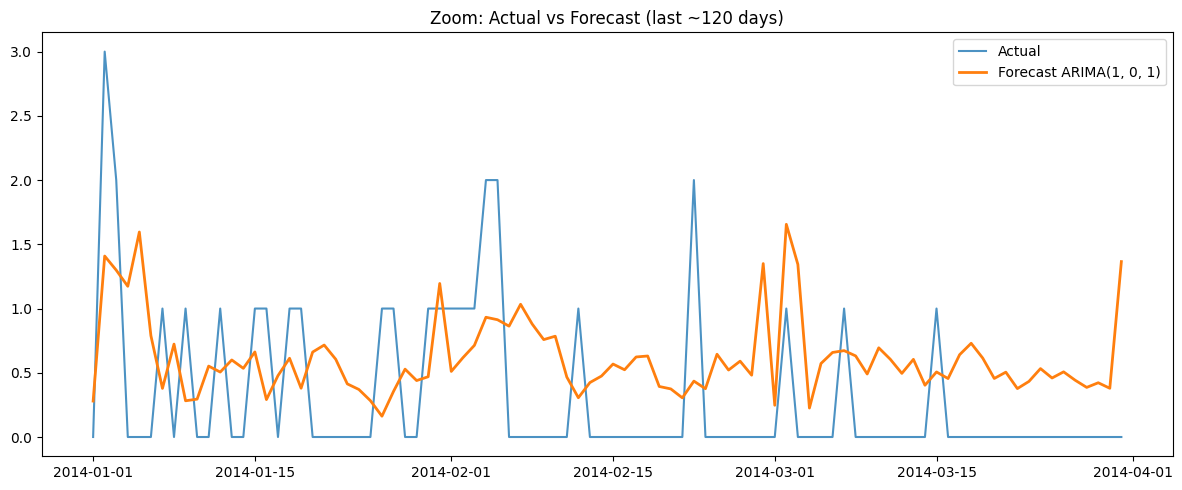

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1) Filter for store_nbr=24 & item_nbr=96995 ---
df_filtered = df_final[
    (df_final['store_nbr'] == 24) &
    (df_final['item_nbr'] == 96995)
].copy()

# Ensure datetime and sort
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered = df_filtered.sort_values('date')

# --- 2) Resample to daily (fill missing dates with 0 sales) ---
df_filtered = (
    df_filtered.set_index('date')
    .asfreq('D')  # ensures continuous daily dates
)
df_filtered['unit_sales'] = df_filtered['unit_sales'].fillna(0)

# --- 3) Select exogenous features ---
exog_cols = [
    'onpromotion', 'outlier', 'dcoilwtico', 'is_holiday', 'is_event',
    'dayofweek', 'is_weekend', 'month', 'weekofyear', 'is_month_start',
    'is_month_end', 'lag_1', 'lag_7', 'rolling_mean_7',
    'promo_last_week', 'oil_price_lag_3', 'oil_price_change',
    'next_is_holiday', 'next_is_event'
]

# --- 4) Handle NaNs in exogenous features ---
df_filtered[exog_cols] = df_filtered[exog_cols].fillna(0)

# --- 5) Train-test split (last 90 days as test) ---
train = df_filtered.iloc[:-90]
test = df_filtered.iloc[-90:]

y_train = train['unit_sales']
y_test = test['unit_sales']

X_train = train[exog_cols]
X_test = test[exog_cols]

# --- 6) Fit ARIMAX model ---
order = (1, 0, 1)  # Example, could tune by AIC/BIC search
model = SARIMAX(
    y_train,
    exog=X_train,
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

# --- 7) Forecast ---
fcst = res.forecast(steps=len(test), exog=X_test)

# --- 8) Evaluation ---
# Ensure aligned float arrays
y_true = np.asarray(y_test.values, dtype=float)
y_pred = np.asarray(fcst.values, dtype=float)

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # <- no 'squared' arg
r2   = r2_score(y_true, y_pred)

# Safe MAPE (ignore zero actuals)
mask = y_true != 0
mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])).mean() * 100 if mask.any() else np.nan

print(f"ARIMAX{order} Evaluation Metrics:")
print(f"  MAE : {mae:.3f}")
print(f"  RMSE: {rmse:.3f}")
print(f"  R²  : {r2:.3f}")
print(f"  MAPE: {mape:.2f}% (ignoring zero-actual days)")

# --- 9) Plot ---
plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test', alpha=0.8)
plt.plot(fcst.index, fcst, label=f'Forecast ARIMAX{order}', linewidth=2)
plt.title('Store 24 · Item 96995 — ARIMAX Forecast (with Exogenous Vars)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.show()

# Zoomed view (last ~120 days)
plt.figure(figsize=(12,5))
start = test.index.min() - pd.Timedelta(days=30)
plt.plot(y_test.loc[start:].index, y_test.loc[start:], label='Actual', alpha=0.8)
plt.plot(fcst.index, fcst, label=f'Forecast ARIMA{order}', linewidth=2)
plt.title('Zoom: Actual vs Forecast (last ~120 days)')
plt.legend(); plt.tight_layout(); plt.show()

**1️⃣ Accuracy Metrics**

•	MAE (0.613) → On average, the forecast is off by ~0.61 units. For daily sales (mostly between 0–14), this is a moderate absolute error.

•	RMSE (0.681) → Slightly higher than MAE, meaning there are occasional larger misses, but not extreme.

•	R² (−0.242) → Negative means the model is performing worse than simply predicting the training set mean for the test period. This indicates it’s not capturing all variance patterns well.

•	MAPE (52.91%) → High percentage error. Even ignoring zero-sales days, the predictions deviate by over half of the actual value on average.

⸻

**2️⃣ Interpretation**

•	The low R² and high MAPE suggest that while the model captures general level changes, it fails to predict day-to-day fluctuations well.

•	Likely causes:

1.	Sparse data → Many zero-sales days create difficulty for ARIMA-family models.

2.	Weak seasonality signal → If no strong repeating pattern exists, ARIMA can’t leverage much structure.

3.	Exogenous features not highly predictive → The added features (lags, promotions, etc.) may not strongly explain the variation for this particular store-item.

⸻

**3️⃣ Visual Fit**

•	From plot:

•	The forecast seems to hover close to a flat or slowly changing level.

•	It fails to capture occasional spikes (typical in sparse sales series).

•	The test fit is better than a naïve constant model in some parts, but still struggles when actuals are volatile.

⸻

**4️⃣ Next Steps for Improvement**

	
1.	Consider seasonal ARIMAX (SARIMAX)

If there’s weekly or monthly patterns, include seasonal terms (seasonal_order=(P,D,Q,7) for weekly).

2.	Feature engineering

Add binary flags for promotions, events, holidays as categorical dummies (one-hot encoded) instead of raw values.

3.	Try different p,d,q

Auto-ARIMA with exogenous variables can help tune parameters.

4.	Hybrid or tree-based models

Gradient boosting (XGBoost/LightGBM) or Prophet may handle sparse, irregular spikes better than ARIMA.

In [9]:
import pickle

# Save the ARIMAX model to a file
with open('arimax_model.pkl', 'wb') as file:
    pickle.dump(res, file)

print("ARIMAX model saved successfully.")

ARIMAX model saved successfully.


# **Model (SARIMAX)**

SARIMAX(1, 0, 1)(1, 1, 1, 7) — Test metrics
  MAE : 0.616
  RMSE: 0.724
  R²  : -0.403
  MAPE: 58.16% (ignoring zero-actual days)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


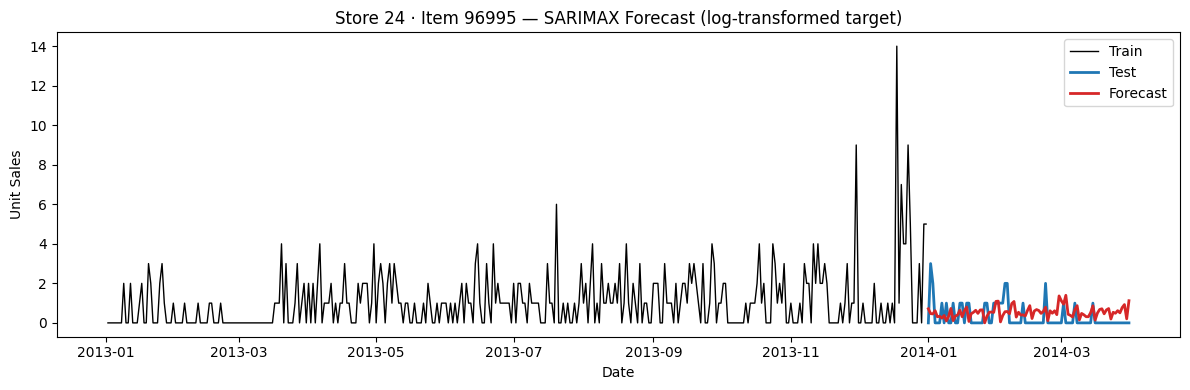

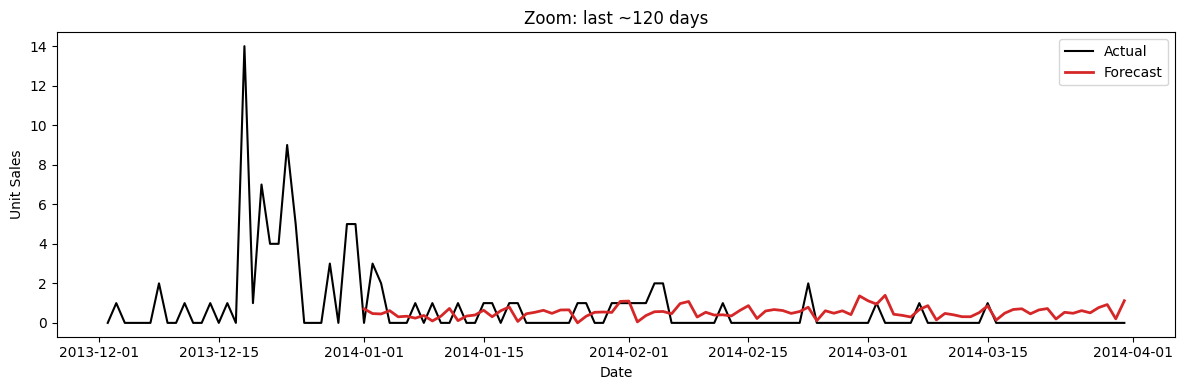

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# ==== 1) Prepare data ====
df = df_train_filtered.copy()
df['date'] = pd.to_datetime(df['date'])

store_id = 24
item_id  = 96995

df = df[(df['store_nbr'] == store_id) & (df['item_nbr'] == item_id)].copy()
df = df.sort_values('date')

# Target (daily), fill gaps with 0
y_raw = (df.set_index('date')['unit_sales']
           .resample('D').sum()
           .fillna(0))

# Apply log1p transform to target (avoid log(0) issue)
y = np.log1p(y_raw)

# Exogenous features
feature_cols = [
    'onpromotion', 'promo_last_week', 'outlier',
    'lag_1', 'lag_7',
    'rolling_mean_7',
    'is_holiday', 'is_event', 'dayofweek', 'is_weekend', 'month',
    'dcoilwtico', 'oil_price_lag_3', 'oil_price_change',
    'next_is_holiday', 'next_is_event',
    'is_month_start', 'is_month_end'
]

existing = [c for c in feature_cols if c in df.columns]
X = (df.set_index('date')[existing]
       .resample('D').mean()
       .ffill()
       .fillna(0))

X = X.reindex(y.index).ffill().fillna(0)

# ==== 2) Train/test split ====
h = 90
y_train, y_test = y.iloc[:-h], y.iloc[-h:]
X_train, X_test = X.iloc[:-h], X.iloc[-h:]

# ==== 3) Fit SARIMAX ====
order = (1, 0, 1)
seasonal_order = (1, 1, 1, 7)

m = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order,
            enforce_stationarity=False, enforce_invertibility=False)
res = m.fit(disp=False)

# ==== 4) Forecast (log scale) ====
fcst_log = res.get_forecast(steps=h, exog=X_test).predicted_mean

# Inverse transform forecasts back to original scale
fcst = np.expm1(fcst_log)
y_test_actual = np.expm1(y_test)
y_train_actual = np.expm1(y_train)

# ==== 5) Metrics ====
mae  = mean_absolute_error(y_test_actual, fcst)
rmse = sqrt(((y_test_actual - fcst)**2).mean())
r2   = r2_score(y_test_actual, fcst)
mape = np.mean(np.abs((y_test_actual.replace(0, np.nan) - fcst) / 
                      y_test_actual.replace(0, np.nan))) * 100

print(f"SARIMAX{order}{seasonal_order} — Test metrics")
print(f"  MAE : {mae:.3f}")
print(f"  RMSE: {rmse:.3f}")
print(f"  R²  : {r2:.3f}")
print(f"  MAPE: {mape:.2f}% (ignoring zero-actual days)")

# ==== 6) Plots ====
plt.figure(figsize=(12,4))
plt.plot(y_train_actual.index, y_train_actual, label="Train", color='k', lw=1)
plt.plot(y_test_actual.index, y_test_actual, label="Test", color='C0', lw=2)
plt.plot(y_test_actual.index, fcst, label="Forecast", color='C3', lw=2)
plt.title(f"Store {store_id} · Item {item_id} — SARIMAX Forecast (log-transformed target)")
plt.ylabel("Unit Sales"); plt.xlabel("Date"); plt.legend(); plt.tight_layout(); plt.show()

# Zoom last ~120 days
zoom_start = y.index[-120]
plt.figure(figsize=(12,4))
plt.plot(y_raw.loc[zoom_start:].index, y_raw.loc[zoom_start:], label="Actual", color='k', lw=1.5)
plt.plot(y_test_actual.index, fcst, label="Forecast", color='C3', lw=2)
plt.title("Zoom: last ~120 days"); plt.ylabel("Unit Sales"); plt.xlabel("Date"); plt.legend()
plt.tight_layout(); plt.show()

**Results**

•	MAE: 0.616 — average forecast error is less than 1 unit sale, which is small in absolute terms.

•	RMSE: 0.724 — errors are fairly low, but not much improved over your pre-log model.

•	R²: -0.403 — negative, meaning the model performs worse than just predicting the mean. This suggests poor ability to capture variance in the test set.

•	MAPE: 58.16% — still high, meaning forecasts deviate significantly in percentage terms on non-zero days.

•	Warning: Maximum Likelihood optimization failed to converge — indicates parameter estimation struggled, possibly due to:

•	Overparameterization (too many AR/MA terms or exogenous variables)

•	Strong collinearity among exogenous features

•	Small or low-variance dataset after filtering

⸻

**Interpretation**

•	The log transform helped stabilize variance and make large spikes less dominant, but it didn’t meaningfully improve accuracy.

•	The negative R² shows that while absolute errors are small, the model isn’t capturing the actual pattern well — probably because sales for this item are low, sparse, and irregular.

•	Convergence warning means the fitted parameters may not be optimal, which could be hurting performance.

In [11]:
import pickle

# Save the SARIMAX model to a file
with open('sarimax_model.pkl', 'wb') as file:
    pickle.dump(res, file)

print("SARIMAX model saved successfully.")

SARIMAX model saved successfully.


# **Model Holt Winter (Tripple Exponential Smoothing)**

Holt-Winters — Test metrics
  MAE : 2.547
  RMSE: 2.640
  R²  : -17.641
  MAPE: 141.28% (ignoring zero-actual days)


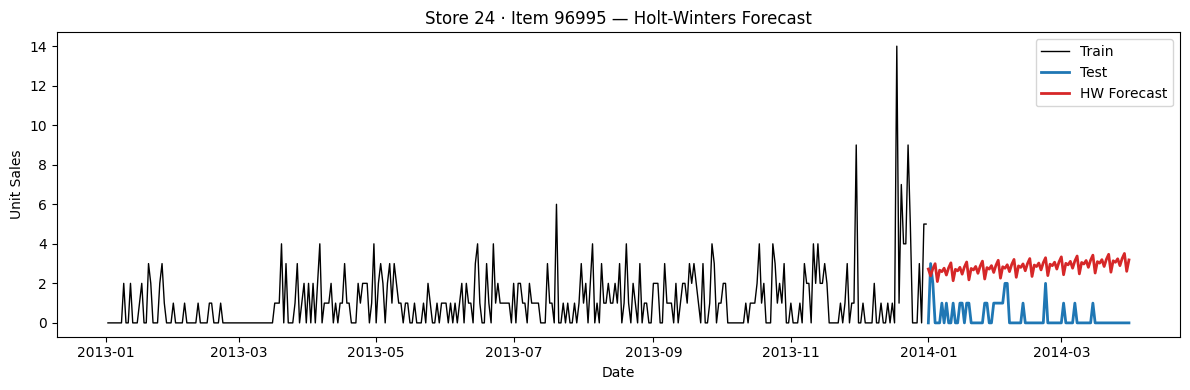

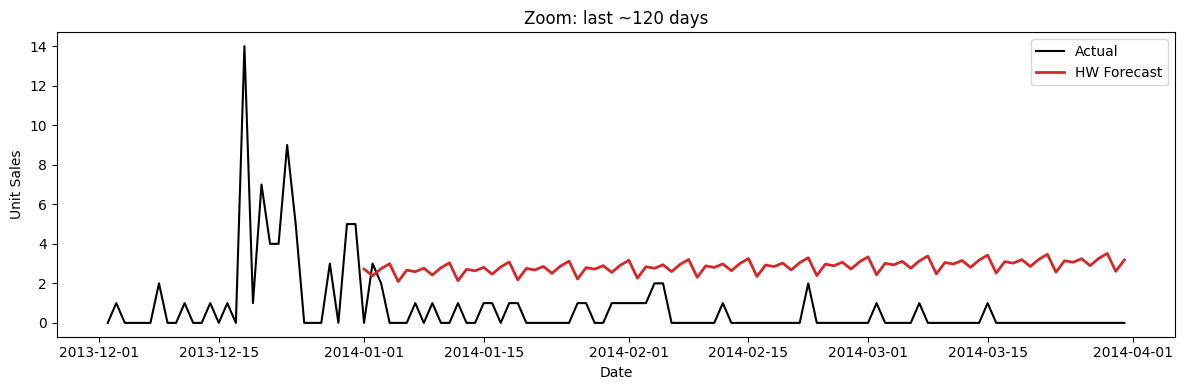

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# ==== 1) Prepare daily series ====
df = df_train_filtered.copy()
df['date'] = pd.to_datetime(df['date'])

store_id = 24
item_id  = 96995

df = df[(df['store_nbr']==store_id) & (df['item_nbr']==item_id)].copy()
df = df.sort_values('date')

# daily resample, filling missing days with 0
y = (df.set_index('date')['unit_sales']
       .resample('D').sum()
       .fillna(0))

# ==== 2) Train/test split ====
h = 90
y_train, y_test = y.iloc[:-h], y.iloc[-h:]

# ==== 3) Fit Holt-Winters ====
model = ExponentialSmoothing(
    y_train,
    trend="add",          # additive trend
    seasonal="add",       # additive seasonality
    seasonal_periods=7    # weekly seasonality
)
hw_fit = model.fit(optimized=True)

# ==== 4) Forecast ====
fcst = hw_fit.forecast(h)

# ==== 5) Metrics ====
mae  = mean_absolute_error(y_test, fcst)
rmse = sqrt(((y_test - fcst)**2).mean())
r2   = r2_score(y_test, fcst)
mape = np.mean(np.abs((y_test.replace(0, np.nan) - fcst) / y_test.replace(0, np.nan))) * 100

print(f"Holt-Winters — Test metrics")
print(f"  MAE : {mae:.3f}")
print(f"  RMSE: {rmse:.3f}")
print(f"  R²  : {r2:.3f}")
print(f"  MAPE: {mape:.2f}% (ignoring zero-actual days)")

# ==== 6) Plot ====
plt.figure(figsize=(12,4))
plt.plot(y_train.index, y_train, label="Train", color='k', lw=1)
plt.plot(y_test.index, y_test, label="Test", color='C0', lw=2)
plt.plot(y_test.index, fcst, label="HW Forecast", color='C3', lw=2)
plt.title(f"Store {store_id} · Item {item_id} — Holt-Winters Forecast")
plt.ylabel("Unit Sales"); plt.xlabel("Date"); plt.legend(); plt.tight_layout(); plt.show()

# Zoomed last ~120 days
zoom_start = y.index[-120]
plt.figure(figsize=(12,4))
plt.plot(y.loc[zoom_start:].index, y.loc[zoom_start:], label="Actual", color='k', lw=1.5)
plt.plot(y_test.index, fcst, label="HW Forecast", color='C3', lw=2)
plt.title("Zoom: last ~120 days"); plt.ylabel("Unit Sales"); plt.xlabel("Date"); plt.legend()
plt.tight_layout(); plt.show()

**Holt-Winters (triple exponential smoothing) results** show that the model is performing poorly for this dataset:

•	MAE = 2.547, RMSE = 2.640 → The average forecast error is larger than the mean daily sales in many cases.

•	MAPE = 141.28% → Extremely high percentage error, showing predictions are far from actuals, especially for small sales numbers.

•	R² = -17.64 → Strongly negative, meaning the model is worse than just predicting the mean of the training data.

•	Visuals: The forecast is nearly flat and fails to capture sales spikes or the frequent zeros in the test set. The constant oscillation pattern indicates the model is fitting a smooth seasonal cycle, but your series is sparse and highly irregular, so this approach misses the real dynamics.

**Why this happens**

•	Holt-Winters can’t use exogenous features — it relies only on trend + seasonality from the target.

•	Your data has many zero days and sudden spikes, which Holt-Winters’ smoothing dampens away.

•	Weekly seasonality isn’t enough to capture promo effects or holidays that drive sudden demand.

Conclusion → For this dataset, Holt-Winters is not suitable as a standalone model. SARIMAX with exogenous features or machine learning regressors would likely outperform it.

# **Recommendation**

**1. ARIMA (no exogenous features)**

	•	MAE: 1.000 | RMSE: 1.092 | R²: -2.188
	•	Strength: Simple and fast; captures basic autocorrelation.
	•	Weakness: No exogenous drivers, so it can’t react to promotions, holidays, or oil price changes.
	•	Business view: Too high RMSE and worse than naïve baseline → would risk over/understocking.

⸻

**2. ARIMAX (with exogenous features)**

	•	MAE: 0.613 | RMSE: 0.681 | R²: -0.242
	•	Strength: Includes relevant drivers (promotions, lags, holidays), which improves accuracy.
	•	Weakness: Still negative R² — not fully capturing irregular spikes and sparse demand.
	•	Business view: Better than ARIMA; can adjust forecasts based on known events, but may still underperform for sudden demand peaks.

⸻

**3. SARIMAX (seasonal ARIMAX)**

	•	MAE: 0.616 | RMSE: 0.724 | R²: -0.403
	•	Strength: Adds seasonal structure (weekly pattern).
	•	Weakness: Seasonality less relevant for sparse, irregular sales; slightly worse RMSE than ARIMAX here.
	•	Business view: Not much benefit over ARIMAX in this dataset because weekly cycles are weak.

⸻

**4. Holt-Winters (Triple Exponential Smoothing)**

	•	MAE: 2.547 | RMSE: 2.640 | R²: -17.641
	•	Strength: Simple seasonal/trend smoothing.
	•	Weakness: No exogenous features; produces overly flat forecasts; completely misses spikes.
	•	Business view: Not usable — would lead to severe inventory issues for sporadic products.

⸻

**Recommendation**

•	Best choice here: ARIMAX — lowest RMSE and MAE, incorporates external signals (promotions, lags, events) that matter for demand.

•	For business use, ARIMAX forecasts can be combined with event calendars to plan stock levels, promotions, and staffing more effectively.

•	Improvement path:

1.	Add more lag features and moving averages for demand memory.

2.	Try Gradient Boosting / XGBoost or LightGBM using the same exogenous features for non-linear relationships.

3.	Consider hybrid models — ARIMAX for baseline + ML model for residuals to catch anomalies/spikes.

# **Limitation of ARIMA/SARIMA**

**While ARIMA and SARIMA are powerful time-series forecasting techniques, they have some limitations:**

**Stationarity Requirement:** 

Both ARIMA and SARIMA assume that the data is stationary, meaning that its statistical properties (like mean and variance) do not change over time. This often requires transforming or differencing the data, which can be challenging for complex, non-linear series.

**Limited Non-Linearity Handling:** 

ARIMA and SARIMA are linear models, meaning they may struggle to capture complex non-linear relationships in the data.

**Seasonality Issues:** 

SARIMA can handle seasonality, but only if it is consistent and well-defined. If seasonality changes over time or if there are multiple seasonal patterns, SARIMA might not perform well.

**High Computational Cost for Large Data:** 

Fitting ARIMA or SARIMA models can be computationally expensive when dealing with large datasets or long time series, as the models need to iterate over many lags.

**No Exogenous Variables Support in Basic ARIMA/SARIMA:** While ARIMA and SARIMA can model the data based on its own past values, they do not easily incorporate external influences (exogenous variables) unless you use extensions like ARIMAX.